In [1]:
# 带一层隐藏层的平面数据分析

"""
目标：
实现一个两层的神经网络，包含一层隐藏层
使用非线性的激活函数，例如：tanh
计算交叉熵的损失?
实现向前和向后传播
"""
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets


In [2]:

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)# 设置一个种子，这样保证结果是一致的？

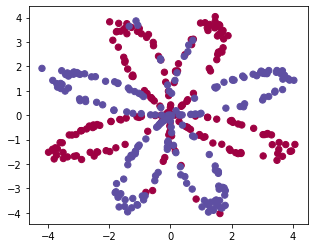

In [3]:
"""
2.Dataset
"""
X, Y = load_planar_dataset()
X = X.reshape(2, -1)
Y = Y.reshape(Y.size, )
# 提供的测试数据源
# A, B = sklearn.datasets.make_moons(200, noise=0.20)
# 可视化数据
plt.scatter(X[0, :], X[1, :], c=Y.reshape(Y.size), s=40, cmap=plt.cm.Spectral)
plt.show()

In [4]:
# 看看变量的形状
shape_X = X.shape
shape_Y = Y.shape
m = shape_X[1]

print('the shape of X is: ' + str(shape_X))
print('the shape of Y is: ' + str(shape_Y))
print('i have m = %d training examples!' % (m))

the shape of X is: (2, 400)
the shape of Y is: (400,)
i have m = 400 training examples!


In [5]:
"""
3.简单的逻辑回归
"""
clf = sklearn.linear_model.LogisticRegressionCV(cv=3)
# print("X shape = " + str(X.shape))
# print("Y shape = " + str(Y.reshape(1, -1)))

# 提醒是要对预测输出y做出ravel()转换，例如下面操作：
#注意ravel和reshape的区别（一个参数的时候没区别，都是转换成不规范形式）
clf.fit(X.T, Y.ravel())


LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

X.shape = (2, 400)
LR_predictions.shape = (400,)
Y.shape = (400,)
np.dot(Y, LR_predictions) = 102
np.dot(1-Y,1-LR_predictions) = 86
Y.size = 400
Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


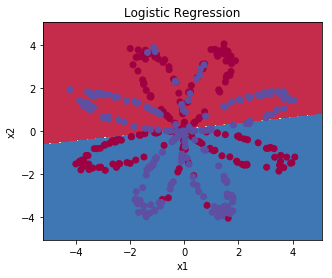

In [10]:
# 我们确定一下模型的边界，观察一下
# 使用了逻辑回归模型
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")
print('X.shape = ' + str(X.shape))
LR_predictions = clf.predict(X.T)
print("LR_predictions.shape = " + str(LR_predictions.shape))
print('Y.shape = ' + str(Y.shape))
print('np.dot(Y, LR_predictions) = ' + str(np.dot(Y, LR_predictions)))
print('np.dot(1-Y,1-LR_predictions) = ' + str(np.dot(1-Y,1-LR_predictions)))
print('Y.size = ' + str(Y.size))
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

In [218]:
# 通过观察，发现逻辑回归并不能很好的拟合数据，如果使用了神经网络就会比较好的拟合了

In [15]:
"""
4. 神经网络模型
"""
"""
我们实现单层隐藏的神经网络
"""
def layer_sizes(X, Y):
    """
    Arguments:
    X -- 输入的数据集
    Y -- shape 对应标签
    """
    n_x = X.shape[0] # 输入层的尺寸
    n_h = 4 # 隐藏层的尺寸， 暂定为4层
    n_y = Y.shape[0] # 输出层的尺寸
    return (n_x, n_h, n_y)

X_assess, Y_assess = layer_sizes_test_case()
# (5, 3)    (2, 3)
n_x, n_h, n_y = layer_sizes(X_assess, Y_assess)
print("X_assess.shape = " + str(X_assess.shape))
print("Y_assess.shape = " + str(Y_assess.shape))

print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

X_assess.shape = (5, 3)
Y_assess.shape = (2, 3)
The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


In [62]:
# 4.2初始化模型的参数
"""
不建议全都初始化为0了，因为这样会造成函数没有效果，而是建议将参数设置成比较小的数字
如果比较大的话，会造成每次更新的参数会很大，乘以学习率之后更新梯度太大
所以设置成比较小的
"""
def initialize_parameters(n_x, n_h, n_y):
    """
    Return:
    parameters -- python dictionary containing parameters:
            W1 -- 尺寸为（n_h, n_x） 的权重矩阵 (hiden_layer_size, input_layer_size)
            b1 -- 尺寸为 (n_h, 1) 标量 (hiden_layer_size, 1)
            W2 -- 尺寸为 (n_y, n_h) 的权重矩阵 (output_layer_size, hiden_layer_size)
            b2 -- 尺寸为 (n_y, 1) 的标量 (output_layer_size, 1)
    """
    np.random.seed(2)
    
    W1 = np.random.rand(n_h, n_x)
    b1 = np.zeros([n_h, 1])
    W2 = np.random.rand(n_y, n_h)
    b2 = np.zeros([n_y, 1])
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
    }
    return parameters

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[0.4359949  0.02592623 0.54966248 0.43532239 0.4203678 ]
 [0.33033482 0.20464863 0.61927097 0.29965467 0.26682728]
 [0.62113383 0.52914209 0.13457995 0.51357812 0.18443987]
 [0.78533515 0.85397529 0.49423684 0.84656149 0.07964548]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[0.50524609 0.0652865  0.42812233 0.09653092]
 [0.12715997 0.59674531 0.226012   0.10694568]]
b2 = [[0.]
 [0.]]


In [63]:
"""
4.3 循环处理
"""
# 实现向前传播
"""
指令说明：
表示我的分类器
可以使用sigmoid函数
也可以使用tanh函数
需要实现的内容是：

"""

def forward_propagation(X, parameters):
    """
    Argument:
    X -- 输入数据的尺寸 (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- S形函数的输出到下一个激活
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # 解包
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # 实现向前传播来计算A2
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1) # 激活函数 z[2](i) = tanh(z[1](i))
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache
    

In [64]:
X_assess, parameters = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters)
print(A2)

[[0.5002307  0.49985831 0.50023963]]


In [65]:

# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    计算损失函数
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- 第二层的 S形函数输出 shape is (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    m = Y.shape[1] # number of examples
    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1 - A2), 1 - Y)
    cost = - np.sum(logprobs) / m
    
    cost = np.squeeze(cost) # 确保 cost 的尺寸是规定的 E.g., [[17]] -> 17
    assert (isinstance(cost, float))
    return cost

In [66]:
A2, Y_assess, parameters = compute_cost_test_case()
print(Y_assess)
print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

[[ 1.62434536 -0.61175641 -0.52817175]]
cost = 0.6929198937772197


In [67]:
"""
向后传播(求导数，用来梯度下降)
"""
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = Y.shape[1]
    
    # 取得参数
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    dZ2 = A2 - Y # 差值
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [68]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


In [105]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [106]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


In [107]:
# 整合， 基本的功能已经实现，现在将功能集中实现
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost = False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    Y.reshape(1, X.shape[1])
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
#     print("W1 = " + str(parameters["W1"]))
#     print("b1 = " + str(parameters["b1"]))
#     print("W2 = " + str(parameters["W2"]))
#     print("b2 = " + str(parameters["b2"]))
    
    cost = 0
    for i in range(0, num_iterations):
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
        
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    return parameters

In [108]:
X_assess, Y_assess = nn_model_test_case()
print(X_assess.shape)
print(Y_assess.shape)
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))


(2, 3)
(1, 3)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


W1 = [[ 4.16831848 -5.34456143]
 [ 7.53013628 -1.24318172]
 [ 4.21675122 -5.31232888]
 [ 7.53007413 -1.24316189]]
b1 = [[-2.32849726]
 [-3.794946  ]
 [-2.32780164]
 [-3.79488518]]
W2 = [[6036.11922193 6010.62869228 6036.02128079 6010.05844659]]
b2 = [[-53.37790112]]


In [109]:
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    return predictions

parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


In [128]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)


Cost after iteration 0: 0.756530
Cost after iteration 1000: 0.078778
Cost after iteration 2000: 0.059735
Cost after iteration 3000: 0.052070
Cost after iteration 4000: 0.047390
Cost after iteration 5000: 0.056426
Cost after iteration 6000: 0.045242
Cost after iteration 7000: 0.043717
Cost after iteration 8000: 0.150267
Cost after iteration 9000: 0.074905


In [129]:
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 98%


Accuracy for 1 hidden units: 70.5 %
Accuracy for 2 hidden units: 83.0 %
Accuracy for 3 hidden units: 98.0 %
Accuracy for 4 hidden units: 97.5 %
Accuracy for 5 hidden units: 100.0 %
Accuracy for 20 hidden units: 100.0 %
Accuracy for 50 hidden units: 100.0 %


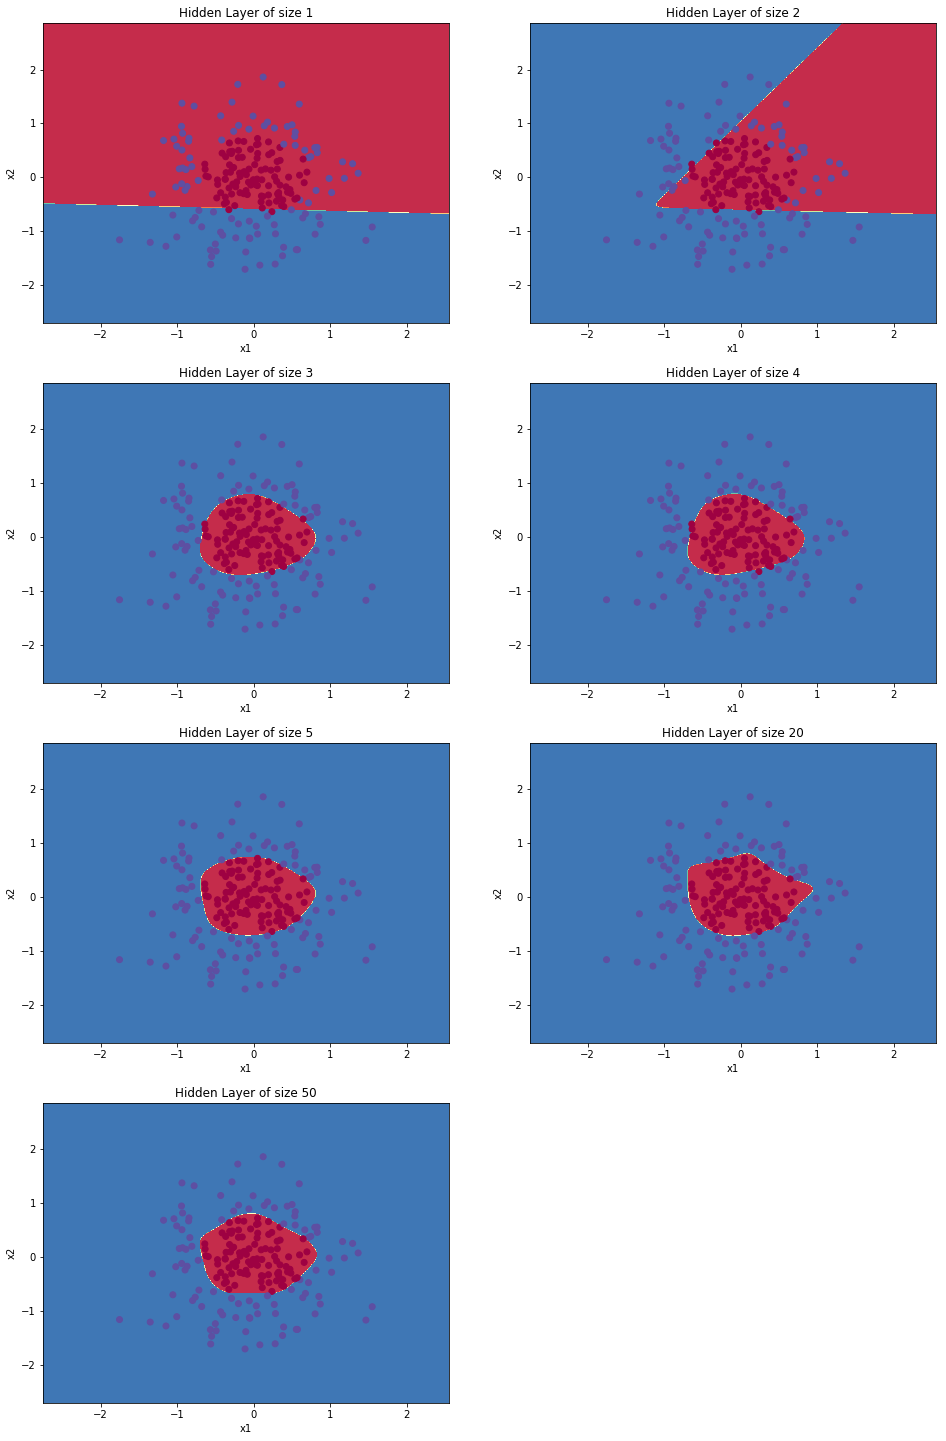

In [130]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0, :])
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

(2, 200)
(1, 200)


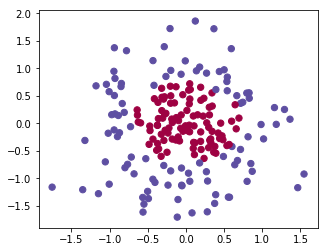

In [127]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "gaussian_quantiles"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

print(X.shape)
print(Y.shape)
# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=np.squeeze(Y), s=40, cmap=plt.cm.Spectral)